In [1]:
from google.colab import drive #connecting to my google drive to access my dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf #downgrading tenorflow to allow deployment on local machine 
print(tf.__version__)

2.2.0


In [3]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.2.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 3.9 kB/s 
     |████████████████████████████████| 2.9 MB 43.2 MB/s 
     |████████████████████████████████| 3.0 MB 54.8 MB/s 
     |████████████████████████████████| 454 kB 46.9 MB/s 
     |████████████████████████████████| 26.1 MB 2.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scipy
    Found 

In [3]:
import tensorflow as tf#checking for successful downgrade of tensorflow version
print(tf.__version__)

2.2.0


In [4]:
#importing necessary libraries 
import os
import random
import glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

In [5]:
#defining training and test path in google drive 
train_path = "/content/drive/MyDrive/Pnuemonia dataset/train"
test_path = "/content/drive/MyDrive/Pnuemonia dataset/test"

In [6]:
#checking for length of the length of the training data set 
print(f"Normal X-Rays From test Set: {len(os.listdir(train_path + '/NORMAL'))} ")
print(f"Pneumonia X-Rays From test Set: {len(os.listdir(train_path + '/PNEUMONIA'))} ")

Normal X-Rays From Validation Set: 1341 
Pneumonia X-Rays From Validation Set: 1797 


In [7]:
#checking for length of the test data set, just 16 images were found , more images are needed 
print(f"Normal X-Rays From test Set: {len(os.listdir(test_path + '/NORMAL'))} ")

print(f"Pneumonia X-Rays From test Set: {len(os.listdir(test_path + '/PNEUMONIA'))} ")

Normal X-Rays From Validation Set: 8 
Pneumonia X-Rays From Validation Set: 8 


In [8]:
#putting the images in the folder into a table 
train_normal = pd.DataFrame({"path": os.listdir(train_path + "/NORMAL"), "label": "NORMAL"})
train_normal["path"] = train_normal["path"].apply(lambda x: train_path + "/NORMAL/" + x)
train_pneumonia = pd.DataFrame({"path": os.listdir(train_path + "/PNEUMONIA"), "label": "PNEUMONIA"})
train_pneumonia["path"] = train_pneumonia["path"].apply(lambda x: train_path + "/PNEUMONIA/" + x)

In [9]:
train_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1797 non-null   object
 1   label   1797 non-null   object
dtypes: object(2)
memory usage: 28.2+ KB


In [10]:
train_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1341 non-null   object
 1   label   1341 non-null   object
dtypes: object(2)
memory usage: 21.1+ KB


In [11]:
#creating the training dataset table through concatenation 
train_df=pd.concat([train_normal,train_pneumonia])
train_df=train_df.reset_index(drop=True)
train_df

,path,label
0,/content/drive/MyDrive/Pnuemonia dataset/train...,NORMAL
1,/content/drive/MyDrive/Pnuemonia dataset/train...,NORMAL
2,/content/drive/MyDrive/Pnuemonia dataset/train...,NORMAL
3,/content/drive/MyDrive/Pnuemonia dataset/train...,NORMAL
4,/content/drive/MyDrive/Pnuemonia dataset/train...,NORMAL
...,...,...
3133,/content/drive/MyDrive/Pnuemonia dataset/train...,PNEUMONIA
3134,/content/drive/MyDrive/Pnuemonia dataset/train...,PNEUMONIA
3135,/content/drive/MyDrive/Pnuemonia dataset/train...,PNEUMONIA
3136,/content/drive/MyDrive/Pnuemonia dataset/train...,PNEUMONIA


In [12]:
test_normal = pd.DataFrame({"path": os.listdir(test_path + "/NORMAL"), "label": "NORMAL"})
test_normal["path"] = test_normal["path"].apply(lambda x: test_path + "/NORMAL/" + x)
test_pneumonia = pd.DataFrame({"path": os.listdir(test_path + "/PNEUMONIA"), "label": "PNEUMONIA"})
test_pneumonia["path"] = test_pneumonia["path"].apply(lambda x: test_path + "/PNEUMONIA/" + x)

test_df = pd.concat([test_normal, test_pneumonia])
test_df=test_df.reset_index(drop=True)

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    16 non-null     object
 1   label   16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


In [14]:
#due to less images in test data set, 15 percent of the training dataset is added to the test dataset 
train_data, test_data = train_test_split(train_df, 
                                        test_size = 0.15, 
                                        random_state =42, 
                                        stratify = train_df["label"], 
                                        shuffle = True)

In [15]:
#concatenating previous test data + 15% of training dataset
test_data = pd.concat([test_df, test_data])

In [16]:
print(f"Training set size after re-splitting training data: {len(train_data)}")
print(f"test set size after re-splitting training data: {len(test_data)}")

Training set size after re-splitting training data: 2667
test set size after re-splitting training data: 487


In [18]:
#trying to copy the updated new test data into a new folder
root_dir="/content/drive/MyDrive"

In [20]:
os.makedirs(root_dir +'/new_test/' + 'Normal')

os.makedirs(root_dir +'/new_test/' + 'Pneumonia')

In [21]:
new_test=test_data

In [22]:
new_test.reset_index(drop=True,inplace=True)

In [23]:
new_test['path'][486].split("/")[7]

'NORMAL2-IM-0539-0001.jpeg'

In [24]:
new_test['default_path']=new_test['path'].apply(lambda x:x.split("/")[7])

In [26]:
#to copy images into the newly created folder 
import shutil 

In [27]:
 for i in range(len(new_test["default_path"])):
   if new_test.iloc[i,1]=='NORMAL':
     shutil.copy(new_test.iloc[i,0],root_dir +'/test/' + 'Normal')
   else:
     shutil.copy(new_test.iloc[i,0],root_dir +'/test/' + 'Pneumonia')


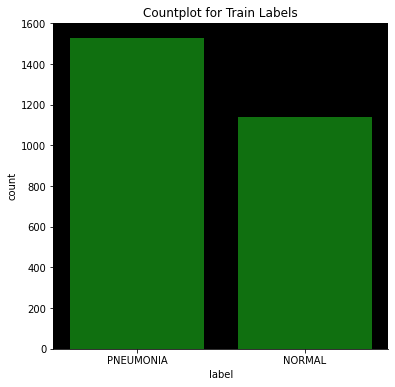

In [28]:
#trying to check if there is any imbalance in our dataset with the aid of a countplot 
fig, ax = plt.subplots(figsize = (6, 6), facecolor = "white")
ax.set_facecolor("black")

sns.countplot(data = train_data, x = "label", ax = ax, color = "green")

ax.set_title("Countplot for Train Labels")

sns.despine()
plt.show()

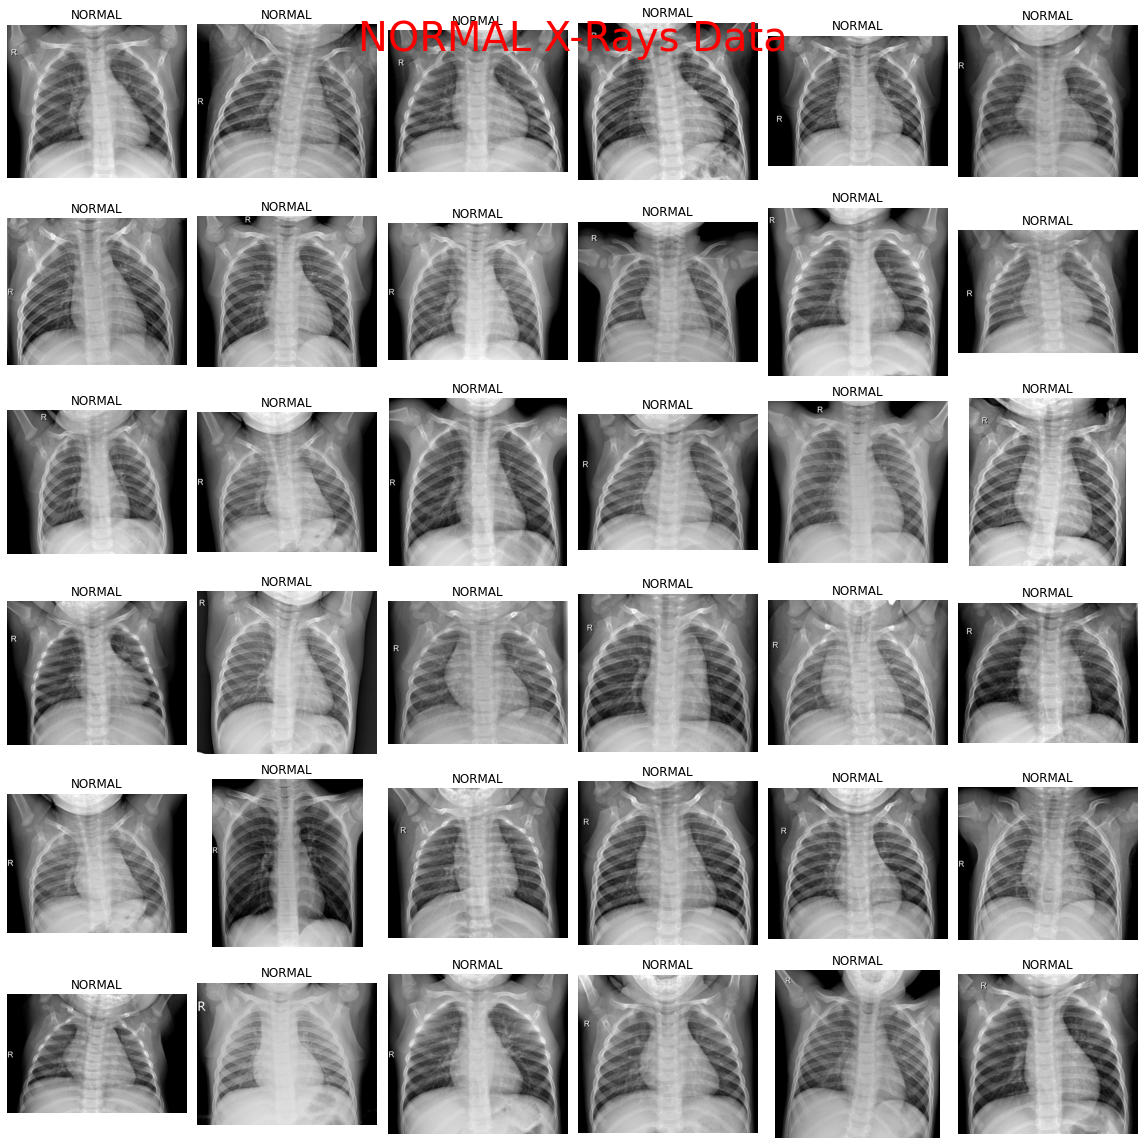

In [29]:
#visualization of normal X-rays Data 
fig=plt.figure(2,figsize=(16,16))
fig.suptitle("NORMAL X-Rays Data", color = 'red', fontsize = 40)
for i in range(36):
    
    ind = random.randint(0, len(train_data.query("label == 'NORMAL'")))
    plt.subplot(6, 6, i + 1)
    image = load_img(train_data.query("label == 'NORMAL'").reset_index()["path"][ind])
    plt.imshow(image)
    plt.title(train_data.query("label == 'NORMAL'").reset_index()["label"][ind])
    plt.axis("off")
    
plt.tight_layout()
plt.show()
    


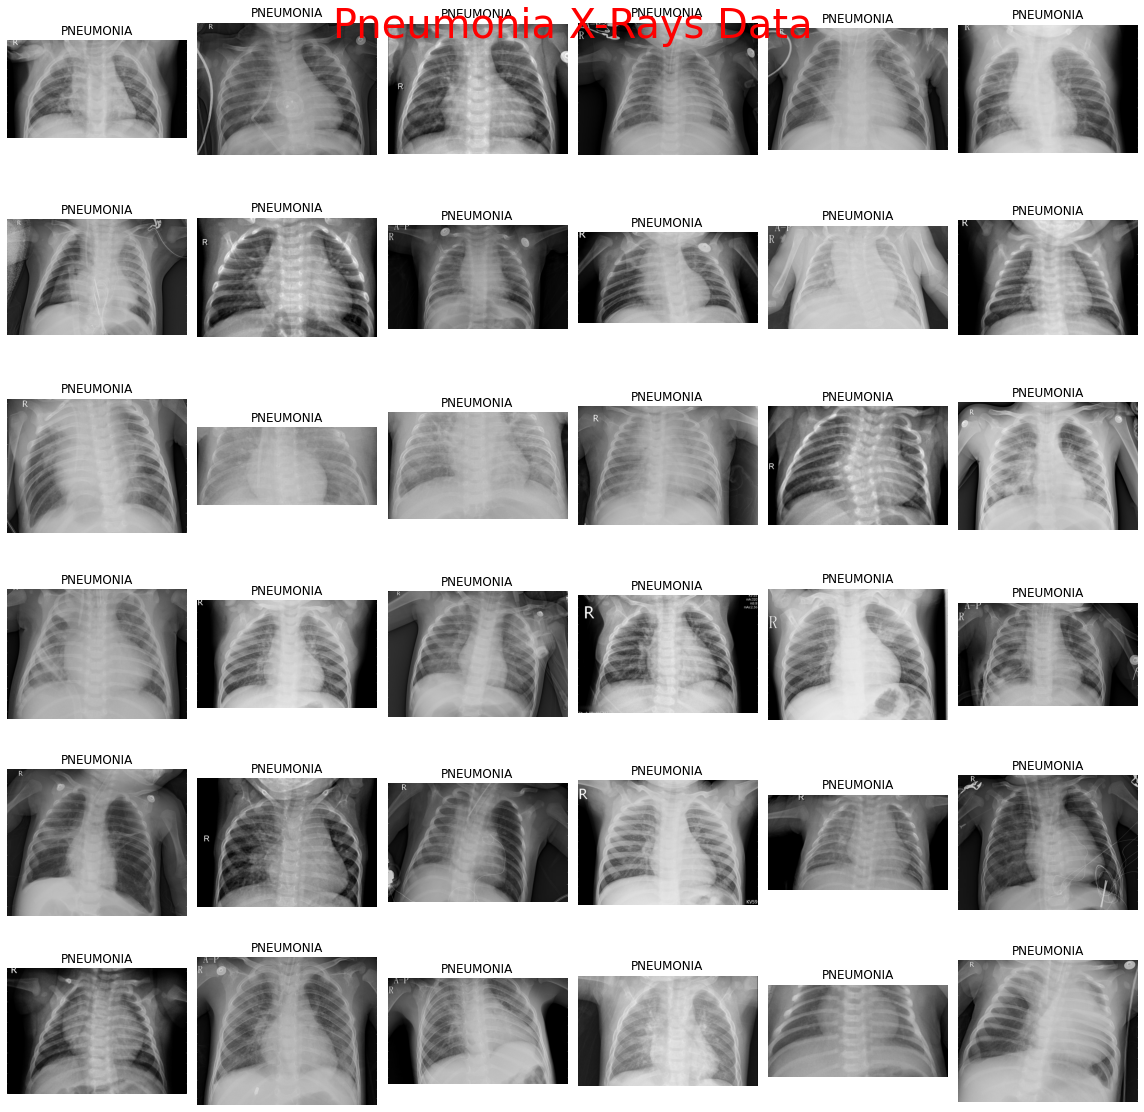

In [30]:
#visualization of pneumonia infected X-rays
fig = plt.figure(1, figsize = (16, 16))
fig.suptitle("Pneumonia X-Rays Data", color = 'red', fontsize = 40)

for i in range(36):
    
    ind = random.randint(0, len(train_data.query("label == 'PNEUMONIA'")))

    plt.subplot(6, 6, i + 1)
    image = load_img(train_data.query("label == 'PNEUMONIA'").reset_index()["path"][ind])
    plt.imshow(image)
    plt.title(train_data.query("label == 'PNEUMONIA'").reset_index()["label"][ind])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Found 1 validated image filenames belonging to 1 classes.


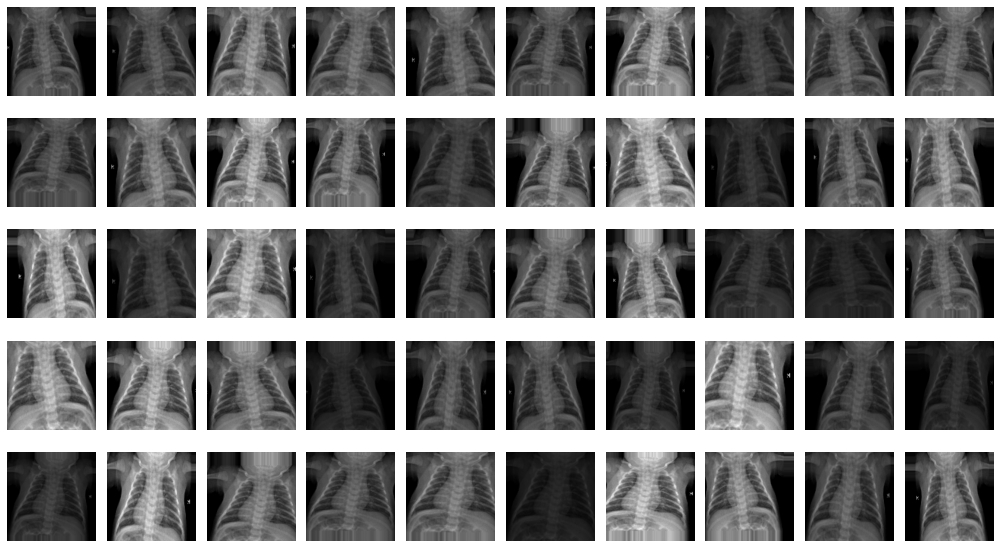

In [36]:
#demonstration and visualization of data augmentation on a single data sample 
datagen = ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rescale = 1./255
)

sample_df = train_data.sample(1)

sample_generator = datagen.flow_from_dataframe(
    dataframe = sample_df,
    x_col = "path",
    y_col = "label",
    class_mode = "categorical",
    target_size = (150, 150),
    seed = 666
)

plt.figure(figsize = (14, 8))

for i in range(50):
    
    plt.subplot(5, 10, i + 1)
    
    for X, y in sample_generator:

        plt.imshow(X[0])
        plt.axis("off")
        break
        
plt.tight_layout()
plt.show()

In [39]:
#data augmentation for the training dataset 
train_datagen = ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input,
)

In [38]:
BATCH_SIZE=32

In [40]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size =BATCH_SIZE,
    shuffle = True,
    seed =42
)

Found 2667 validated image filenames belonging to 2 classes.


In [41]:
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)


In [42]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    x_col = "path",
    y_col = "label",
    target_size = (150, 150),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42
)

Found 487 validated image filenames belonging to 2 classes.


In [43]:
#definition of the desnet121 model, modifying the output layer to suit our use case
base_model = DenseNet121(include_top = False, weights = "imagenet", input_shape = (150, 150, 3))

    
def dense121_pretrained():
    
    model = Sequential(
        [
            base_model,
            Flatten(),
            Dense(128, activation = "relu"),
            Dropout(0.4),
            Dense(2, activation = "softmax")
        ]
    )
    
    return model

29089792/29084464 [==============================] - 0s 0us/step


In [44]:
#model summary 
model = dense121_pretrained()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 9,135,042
Trainable params: 9,051,394
Non-trainable params: 83,648
_________________________________________________________________


In [45]:
class_weights = compute_class_weight("balanced", classes = np.unique(train_data.label), y = train_data.label)

class_weights = {0: class_weights[0], 1: class_weights[1]}

In [46]:
# definition of parameters to guard the training process 
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.0000001,
    cooldown = 1
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    verbose = 1,
    mode = "max",
    )

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "pneumonia_densenet121_.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

In [47]:
#model training 
history = model.fit(
    train_generator,
    epochs = 17, 
    batch_size = BATCH_SIZE,
    validation_data = test_generator,
     validation_steps = test_data.shape[0] // BATCH_SIZE,
    steps_per_epoch = train_data.shape[0] // BATCH_SIZE,
    callbacks = [reduce_lr, early_stopping, checkpoint],
    class_weight = class_weights
   
)

Epoch 1/17
83/83 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.8015
Epoch 00001: val_accuracy improved from -inf to 0.82708, saving model to pneumonia_densenet121_.01-0.827083.hdf5
83/83 [==============================] - 681s 8s/step - loss: 0.7108 - accuracy: 0.8015 - val_loss: 43.5769 - val_accuracy: 0.8271 - lr: 0.0010
Epoch 2/17
83/83 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9055
Epoch 00002: val_accuracy improved from 0.82708 to 0.93333, saving model to pneumonia_densenet121_.02-0.933333.hdf5
83/83 [==============================] - 62s 753ms/step - loss: 0.2534 - accuracy: 0.9055 - val_loss: 0.2461 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 3/17
83/83 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9237
Epoch 00003: val_accuracy improved from 0.93333 to 0.93958, saving model to pneumonia_densenet121_.03-0.939583.hdf5
83/83 [==============================] - 81s 977ms/step - loss: 0.2145 - accuracy: 0

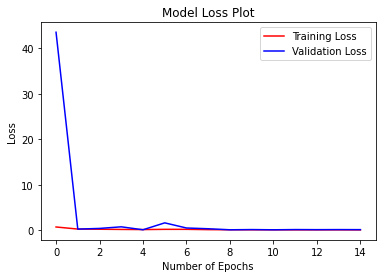

In [48]:
#plotting loss curves 
plt.plot(history.history['loss'], color = 'red', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Validation Loss')
plt.title('Model Loss Plot')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

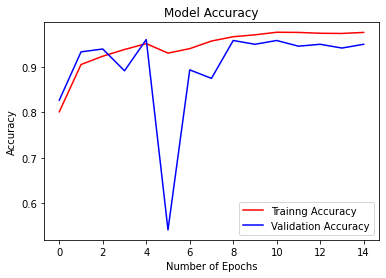

In [49]:
#plotting model's accuracy curves 
plt.plot(history.history['accuracy'], color = 'red', label = 'Trainng Accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
#defining a function to predict the test dataset in order to evaluate the model's accuracy
from tensorflow.keras.preprocessing import image
y_pred=[]
def predict(img):
  
  img = image.load_img(img, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  pred=np.ndarray.item(np.argmax(preds, axis=1))
  y_pred.append(pred)


In [53]:
#calling the predict function
for im in test_data['path']:
  predict(im)


In [54]:
#model evaluation with different metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

In [55]:
test_data['label']=np.where(test_data['label']=='NORMAL',0,1)
y_test=test_data['label']

In [56]:
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred)*100:2f}")

The accuracy of the model is 94.866530


In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       209
           1       1.00      0.91      0.95       278

    accuracy                           0.95       487
   macro avg       0.95      0.95      0.95       487
weighted avg       0.95      0.95      0.95       487



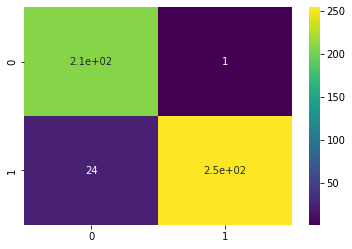

In [65]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="viridis")

In [66]:
#model saving for deployment process 
from tensorflow.keras.models import load_model
model.save('model2.h5')